In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
torch.manual_seed(10)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [3]:
mean = 0.5
std_dev = 0.25

In [4]:
transform1 = transforms.Compose([
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean,std_dev)
])
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std_dev)
])

In [5]:
train_data = torchvision.datasets.MNIST(
    root='../datasets',
    train = True,
    transform=transform2 #download is False in default
)

test_data = torchvision.datasets.MNIST(
    root='../datasets',
    train = False,
    transform=transform2
)

In [6]:
len(train_data)

60000

In [7]:
num_epochs = 50
batch_size = 256
learning_rate = 1e-3

In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_data,
    batch_size = batch_size,
    shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_data,
    batch_size = batch_size,
    shuffle = True
)

In [9]:
len(train_loader)

235

In [10]:
def imshow(img, label):
    img = img * std_dev + mean  # unnormalize
    plt.imshow(img.reshape(img.shape[1],img.shape[2],img.shape[0]))
    plt.title(f'Label {label}')
    plt.show()

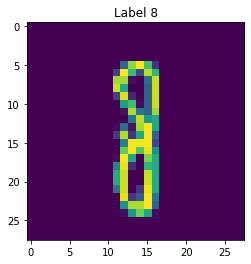

In [11]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(images[2],labels[2])

In [12]:
images.shape

torch.Size([256, 1, 28, 28])

In [13]:
class myResNet(nn.Module):
    def __init__(self) -> None:
        super(myResNet, self).__init__()

        self.conv1_1 = nn.Conv2d(1,4,5,1,'same') #1, 28, 28
        # self.act1_1 = nn.ReLU() 
        self.norm1_1 = nn.BatchNorm2d(4)

        self.conv1_2 = nn.Conv2d(4,4,5,1,'same') # 4, 28, 28
        # self.act1_2 = nn.ReLU()
        self.norm1_2 = nn.BatchNorm2d(4)
            
        self.pool1 = nn.MaxPool2d(2, 2) # 4, 28, 28 --> 4, 14, 14
        
        self.conv2_1 = nn.Conv2d(4,16,3,1,'same')
        # self.act2_1 = nn.ReLU()
        self.norm2_1 = nn.BatchNorm2d(16)
            
        self.conv2_2 = nn.Conv2d(16,16,3,1,'same')
        # self.act2_2 = nn.ReLU()
        self.norm2_2 = nn.BatchNorm2d(16)
        
        self.pool2 = nn.MaxPool2d(2, 2) # 16, 14, 14 --> 16, 7, 7

        self.conv1to3 = nn.Conv2d(1,64,3,1,'same') #1, 28, 28 --> 64, 28, 28
        self.maxpool1to3 = nn.MaxPool2d(4,4) # 64, 28, 28 --> 64, 7, 7

        self.conv3_1 = nn.Conv2d(16,64,3,1,'same') # 16, 7, 7 --> 64, 7, 7
        # self.act3_1 = nn.ReLU()
        self.norm3_1 = nn.BatchNorm2d(64)
            
        self.conv3_2 = nn.Conv2d(64,64,3,1,'same') # 64, 7, 7 --> 64, 7, 7
        # self.act3_2 = nn.ReLU()
        self.norm3_2 = nn.BatchNorm2d(64)

        self.pool3 = nn.MaxPool2d(2, 2) # 64, 7, 7 --> 64, 3, 3

        self.conv2to4 = nn.Conv2d(4,256,3,1,'same') #4, 14, 14 --> 256, 14, 14
        self.maxpool2to4 = nn.MaxPool2d(4,4) # 256, 14, 14 --> 256, 3, 3

        self.conv4_1 = nn.Conv2d(64,256,3,1,'same') # 64, 3, 3 --> 256, 3, 3
        # self.act4_1 = nn.ReLU()
        self.norm4_1 = nn.BatchNorm2d(256)
            
        self.conv4_2 = nn.Conv2d(256,256,3,1,'same') # 256, 3, 3 --> 256, 3, 3
        # self.act4_2 = nn.ReLU()
        self.norm4_2 = nn.BatchNorm2d(256)

        self.lin4 = nn.Linear(256*3*3, 100)
        # self.act4 = nn.ReLU()
        self.norm4 = nn.BatchNorm1d(100)

        self.flatten = nn.Flatten()

        self.lin4_res = nn.Linear(256*3*3, 80)

        self.lin5 = nn.Linear(100, 80)
        # self.act5 = nn.ReLU()
        self.norm5 = nn.BatchNorm1d(80)

        self.lin6 = nn.Linear(80,10)
    
    def forward(self, x):
        x_temp1= x
        x = self.conv1_1(x)
        x1 = self.norm1_1(torch.relu(x))
        x = self.norm1_2(torch.relu(self.conv1_2(x1)+x)) # Residual
        x = self.pool1(x)

        x_temp2 = x
        x = self.conv2_1(x)
        x1 = self.norm2_1(torch.relu(x))
        x = self.norm2_2(torch.relu(self.conv2_2(x1)+x)) # Residual
        x = self.pool2(x)

        x = self.conv3_1(x)
        x_temp1 = self.maxpool1to3(self.conv1to3(x_temp1)) # Nested Residual
        x1 = self.norm3_1(torch.relu(x+x_temp1))
        x = self.norm3_2(torch.relu(self.conv3_2(x1)+x)) # Residual
        x = self.pool3(x)

        x = self.conv4_1(x)
        x_temp2 = self.maxpool2to4(self.conv2to4(x_temp2))
        x1 = self.norm4_1(torch.relu(x+x_temp2))
        x = self.norm4_2(torch.relu(self.conv4_2(x1)+x)) # Residual

        x = self.flatten(x)

        x1 = self.norm4(torch.relu(self.lin4(x)))

        x = self.norm5(torch.relu(self.lin5(x1) + self.lin4_res(x)))
        x = self.lin6(x)
        return(x)

In [14]:
resnet = myResNet().to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 9, gamma = 0.5)

In [16]:
summary(resnet, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]             104
       BatchNorm2d-2            [-1, 4, 28, 28]               8
            Conv2d-3            [-1, 4, 28, 28]             404
       BatchNorm2d-4            [-1, 4, 28, 28]               8
         MaxPool2d-5            [-1, 4, 14, 14]               0
            Conv2d-6           [-1, 16, 14, 14]             592
       BatchNorm2d-7           [-1, 16, 14, 14]              32
            Conv2d-8           [-1, 16, 14, 14]           2,320
       BatchNorm2d-9           [-1, 16, 14, 14]              32
        MaxPool2d-10             [-1, 16, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]           9,280
           Conv2d-12           [-1, 64, 28, 28]             640
        MaxPool2d-13             [-1, 64, 7, 7]               0
      BatchNorm2d-14             [-1, 6

In [17]:
best_weights = copy.deepcopy(resnet.state_dict())
max = 0
val_acc = 0
train_acc = 0
for epoch in range(num_epochs):
    resnet.train()
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        preds = resnet.forward(images)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step() # Decaying learning rate per 25 epochs by 0.2 times
    print(f'Epoch {epoch+1}/{num_epochs}; Loss = {loss.item():.6f}; LR = {scheduler.get_last_lr()}')
    with torch.no_grad():
        n_samples = 0
        n_correct = 0
        resnet.eval()
        for images, labels in test_loader:
            images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
            labels = labels.to(device)
            pred_outputs1 = resnet(images)
            _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
            n_samples += labels.shape[0]
            n_correct += (actual_preds1 == labels).sum().item()
        val_acc = n_correct/n_samples * 100

        if (max <= (n_correct/n_samples * 100)):
            print('SAVED MODEL WEIGHTS')
            max = val_acc
            best_weights = copy.deepcopy(resnet.state_dict())

        n_samples = 0
        n_correct = 0
        
        for images, labels in train_loader:
            images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
            labels = labels.to(device)
            pred_outputs1 = resnet(images)
            _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
            n_samples += labels.shape[0]
            n_correct += (actual_preds1 == labels).sum().item()
        train_acc = n_correct/n_samples * 100
    
    print(f'Train Accuracy: {train_acc:.2f}%')
    print(f'Dev Accuracy: {val_acc:.2f}%')
    print("-"*20)

Epoch 1/50; Loss = 0.077578; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.11%
Dev Accuracy: 98.78%
--------------------
Epoch 2/50; Loss = 0.068342; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.44%
Dev Accuracy: 99.02%
--------------------
Epoch 3/50; Loss = 0.005129; LR = [0.001]
Train Accuracy: 99.50%
Dev Accuracy: 98.90%
--------------------
Epoch 4/50; Loss = 0.002943; LR = [0.001]
Train Accuracy: 99.54%
Dev Accuracy: 98.88%
--------------------
Epoch 5/50; Loss = 0.080631; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.72%
Dev Accuracy: 99.15%
--------------------
Epoch 6/50; Loss = 0.003149; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.81%
Dev Accuracy: 99.22%
--------------------
Epoch 7/50; Loss = 0.000553; LR = [0.001]
Train Accuracy: 99.76%
Dev Accuracy: 99.09%
--------------------
Epoch 8/50; Loss = 0.063486; LR = [0.001]
Train Accuracy: 99.80%
Dev Accuracy: 99.08%
--------------------
Epoch 9/50; Loss = 0.032567; LR = [0.0005]
SAVED MODEL WEIGHTS
T

In [18]:
# resnet.load_state_dict(best_weights)
# torch.save(resnet, 'models/nested_resnet_mnist.pt')